In [1]:
import pandas as pd
import numpy as np
from numpy import newaxis
import random
import itertools
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.collections
from matplotlib import gridspec
from sklearn.model_selection import train_test_split
from tqdm import *

import keras
from keras.applications import *
import lightgbm as lgbm
from scipy import stats
from keras.models import Sequential, Model
from keras.layers import * #Dense, Dropout, Activation, Flatten, Input,Concatenate, concatenate
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
import cv2 as cv
from os import listdir
from os.path import isfile, join
from scipy import misc
from keras.optimizers import Adam
import copy, numpy as np
np.random.seed(0)

Using TensorFlow backend.


In [2]:
plt.ion()
plt.show()

In [3]:
xx = pd.read_pickle('data/somedata.pkl')
xx.head()

,Unnamed: 0,deb_idx,mat_idx,p_month,quantity,volume,revenue,price
13480,13480,2239673,60.0,5,1,0.0,25.9,25.9
15328,15328,2147617,60.0,1,1,0.0,19.9,19.9
19902,19902,2115828,60.0,1,1,0.0,19.9,19.9
24656,24656,2239663,60.0,7,1,0.0,25.9,25.9
25456,25456,2070824,60.0,7,2,0.0,40.4,20.2



  p_month Unnamed: 0    deb_idx mat_idx quantity volume revenue  price
              median     median  median   median median  median median
0       1  6400864.5  2147613.5    60.0        1    0.0    22.9   22.9
1       2  6460271.0  2148675.0    60.0        1    0.0    22.9   22.9
2       3  7066004.5  2147613.5    60.0        1    0.0    22.9   22.9
3       4  6258258.0  2145646.5    60.0        1    0.0    22.9   22.9
4       5  7374922.5  2145220.5    60.0        1    0.0    22.9   22.9


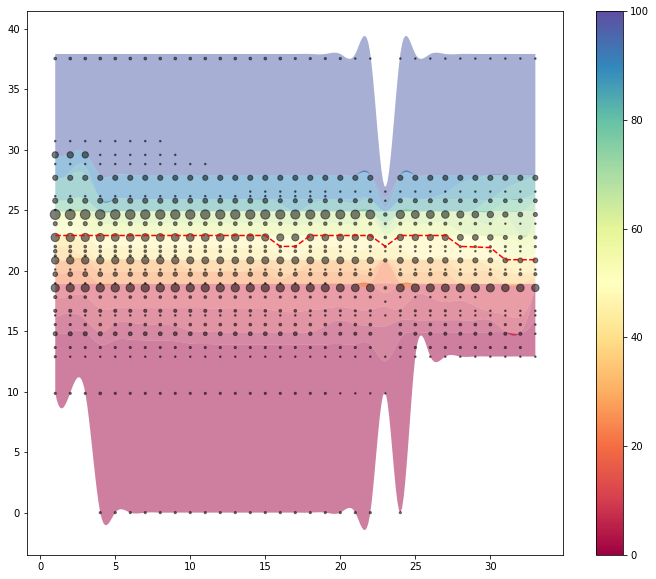

In [7]:
from scipy.interpolate import spline, BSpline, interp1d
import matplotlib.cm
from matplotlib.cm import get_cmap
 
def plotTimeDistribution(data, index, values, numBins=20, cmap='Spectral', distAlpha=0.5, scatterBins=100, interp='cubic'):
    ax = plt.subplot(111)
   
    def perBin(x, numBins):
        return [np.percentile(x,curBin*(100/(numBins))) for curBin in range(0, numBins+1)]
 
    percentiles = data.pivot_table(index=index, values=values, aggfunc=[lambda x: perBin(x,numBins)]).iloc[:,0].values
    percentiles = np.stack(percentiles)
 
    meansStd = data.groupby(index).agg(['median']).reset_index()
    sortedIndices = meansStd[index].values
 
    cmap = get_cmap(cmap)
    distAlpha = 0.5
 
    halfBins = (numBins+1)//2
    xnew = np.linspace(min(data[index]),max(data[index]),300)
   
    mii = min(data[values])
    maa = max(data[values])
   
    for i in range(numBins):
        rgba = cmap(i/(numBins))
 
        # draw the slices of area
        fy1 = percentiles[:,i]
        fy2 = percentiles[:,i+1]
 
        finterp1 = interp1d(sortedIndices, fy1, kind=interp)
        finterp2 = interp1d(sortedIndices, fy2, kind=interp)
        ax.fill_between(xnew, finterp1(xnew) ,finterp2(xnew), alpha=distAlpha, facecolor=rgba)
        
    #draw the scatter plot of values, but scatterBins
   
    bins = np.arange(mii, maa, (maa-mii)/scatterBins)
    tmp = data.copy()
#     print("tmp[values].values", tmp[values].values)
#     print('bins ', bins)
#     print('np.digitize(tmp[values].values, bins)', np.digitize(tmp[values].values, bins))
    tmp['valuesBinned'] = bins[np.digitize(tmp[values].values, bins)-1]
    xxx = tmp.groupby([index, 'valuesBinned']).agg('count').reset_index()
   
    maxCount = max(xxx[xxx.columns[2]].values)
    maxAcceptablePointSize = 100
    pointSizeRatio = maxAcceptablePointSize/maxCount
 
    plt.scatter(x=xxx[index].values, y=xxx['valuesBinned'].values, s=xxx[xxx.columns[2]].values*pointSizeRatio, c='k', alpha=0.5, marker='o')
    print()
       
    meansStd = data.groupby(index).agg(['median']).reset_index()
    print(meansStd.head())
 
    plt.plot(meansStd.p_month.values,meansStd[('price', 'median')].values, c='r', linestyle='--')
   
    m = matplotlib.cm.ScalarMappable(cmap=cmap)
    m.set_array(np.array([100,0]))
    plt.colorbar(m)
   
plt.figure(figsize=(12,10))
plotTimeDistribution(xx, 'p_month', 'price', cmap='Spectral', numBins=30, scatterBins=100)